In [ ]:
#| default_exp learn

In [ ]:
#| export
from torcheval.metrics import MulticlassAccuracy, Mean
from typing import Any, Callable, Sequence, Mapping
from torch.optim.lr_scheduler import ExponentialLR
from fastprogress import progress_bar, master_bar
from operator import attrgetter
import matplotlib.pyplot as plt
from functools import partial
from torch.nn import Module
import fastcore.all as fc
from tts_0.data import *
from torch import optim
from copy import copy
import math
import torch

/Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <7702F607-92FA-3D67-9D09-0710D936B85A> /Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <1E9FA061-EA31-3736-81D0-79A33B965097> /Users/tk541/mambaforge/envs/torch/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
#| hide
from datasets import load_dataset
import torchvision.transforms.functional as TF

# Learner

In [ ]:
#| hide
x, y = "image", "label"
name = "fashion_mnist"
dsd = load_dataset(name)

def transform(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    return b

bs = 1024
tds = dsd.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs)

Found cached dataset fashion_mnist (/Users/tk541/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#| hide
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#| hide
def get_model():
    model = nn.Sequential(nn.Linear(784, 200), nn.ReLU(), nn.Linear(200, 10))
    return model

In [ ]:
#| export
class Callback:
    order = 0

In [ ]:
#| export
class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [ ]:
#| export
class WithCB:
    def __init__(self, name: str) -> None:
        self.name = name
    
    def __call__(self, fn: Callable) -> Callable:
        def _fn(obj: object, *args, **kwargs):
            try:
                obj.callback(f"before_{self.name}")
                fn(obj, *args, **kwargs)
                obj.callback(f"after_{self.name}")  
            except globals()[f"Cancel{self.name.capitalize()}Exception"]:
                pass
            finally:
                obj.callback(f"cleanup_{self.name}")
                
        return _fn

In [ ]:
#| export
class LRFinderCB(Callback):
    def __init__(self, gamma: float = 1.3, max_mult: float = 2.5) -> None:
        fc.store_attr()
    
    def before_fit(self, learn) -> None:
        self.losses, self.lrs, self.min = [], [], math.inf
        learn.scheduler = ExponentialLR(learn.optimizer, self.gamma)
    
    def after_batch(self, learn) -> None:
        if not learn.training:
            raise CancelEpochException()
        
        lr = learn.optimizer.param_groups[0]['lr']
        loss = to_cpu(learn.loss)
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        self.min = min(self.min, loss)
        if math.isnan(loss) or loss > self.min*self.max_mult:
            raise CancelFitException()
        
        learn.scheduler.step()
    
    def cleanup_fit(self, learn) -> None:
        plt.plot(self.lrs, self.losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")

In [ ]:
#| export
class Learner:
    def __init__(self, model: Module, dls: DataLoaders, loss_fn: Callable, lr: float = 0.1, 
                 cbs: Sequence[Callback] = (), optimizer_fn: Callable = optim.SGD) -> None:
        fc.store_attr()
    
    def __getattr__(self, attribute) -> Callable:
        if attribute in ["predict", "get_loss", "backward", "step", "zero_grad"]:
            return partial(self.callback, attribute)
        raise AttributeError(attribute)
    
    @property
    def training(self) -> bool:
        return self.model.training
    
    def callback(self, method_name: str) -> None:
        self._run_callback(self.cbs, method_name)
    
    def _run_callback(self, cbs: Sequence[Callback], method_name: str) -> None:
        for cb in sorted(cbs, key=attrgetter("order")):
            method = getattr(cb, method_name, None)
            if method is not None: method(self)
                
    def fit(self, n_epochs: int, train: bool = True, valid: bool = True, 
            cbs: Sequence[Callback] = (), lr: float = None) -> None:
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            
            if lr is None: lr = self.lr
                
            if self.optimizer_fn: 
                self.optimizer = self.optimizer_fn(self.model.parameters(), lr)
            
            self._fit(train, valid)            
        finally:
            for cb in cbs: self.cbs.remove(cb)
    
    @WithCB("fit")
    def _fit(self, train: bool, valid: bool) -> None:
        for self.epoch in self.epochs:
            if train: self.one_epoch(training=True)
            if valid: torch.no_grad()(self.one_epoch)(training=False)
    
    def one_epoch(self, training: bool) -> None:
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()
    
    @WithCB("epoch")
    def _one_epoch(self) -> None:
        for self.iter, self.batch in enumerate(self.dl):
            self._one_batch()
    
    @WithCB("batch")
    def _one_batch(self) -> None:
        self.predict()
        self.callback("after_predict")
        self.get_loss()
        self.callback("after_loss")
        if self.training:
            self.backward()
            self.callback("after_backward")
            self.step()
            self.callback("after_step")
            self.zero_grad()
            
    def lr_find(self, gamma: float = 1.3, max_mult: float = 2.5, 
                start_lr: float = 1e-5, max_epochs: int = 10):
        self.fit(max_epochs, train=True, valid=False, cbs=[LRFinderCB(gamma, max_mult)], 
                 lr=start_lr)

In [ ]:
#| export
class TrainLearner(Learner):
    def predict(self) -> None:
        x = self.batch[0]
        self.preds = self.model(x)
    
    def get_loss(self) -> None:
        y = self.batch[1]
        self.loss = self.loss_fn(self.preds, y)
    
    def backward(self) -> None:
        self.loss.backward()
    
    def step(self) -> None:
        self.optimizer.step()
    
    def zero_grad(self) -> None:
        self.optimizer.zero_grad()

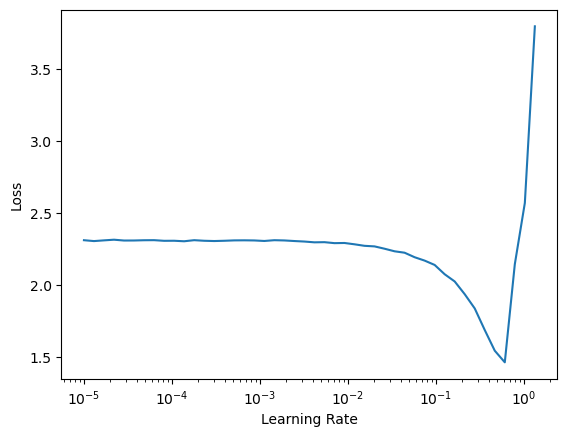

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=[]).lr_find()

In [ ]:
#| export
class CountBatchsCB(Callback):
    count = 0
    def after_batch(self, learn: Learner) -> None:
        self.count += 1
    
    def cleanup_fit(self, learn: Learner) -> None:
        print(f"Number of Batches: {self.count}")

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=[CountBatchsCB()]).fit(1)

Number of Batches: 69


In [ ]:
#| export
class SingleBatchCB(Callback):
    def after_batch(self, learn: Learner) -> None:
        raise CancelFitException()

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=[CountBatchsCB(), SingleBatchCB()]).fit(1)

Number of Batches: 1


In [ ]:
#| export
class TrainCB(Callback):
    def __init__(self, n_inputs: int = 1) -> None:
        self.n_inputs = n_inputs
    
    def predict(self, learn: Learner) -> None:
        x = learn.batch[:self.n_inputs]
        learn.preds = learn.model(*x)
    
    def get_loss(self, learn: Learner) -> None:
        y = learn.batch[self.n_inputs:]
        learn.loss = learn.loss_fn(learn.preds, *y)
    
    def backward(self, learn: Learner) -> None:
        learn.loss.backward()
    
    def step(self, learn: Learner) -> None:
        learn.optimizer.step()
    
    def zero_grad(self, learn: Learner) -> None:
        learn.optimizer.zero_grad()

In [ ]:
Learner(get_model(), dls, F.cross_entropy, cbs=[TrainCB(), CountBatchsCB()]).fit(1)

Number of Batches: 69


In [ ]:
#| export
class DeviceCB(Callback):
    def __init__(self, device: str = def_device) -> None:
        self.device = device
    
    def before_fit(self, learn: Learner) -> None:
        if hasattr(learn.model, "to"):
            learn.model.to(self.device)
    
    def before_batch(self, learn: Learner) -> None:
        learn.batch = to_device(learn.batch, device=self.device)

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB(), CountBatchsCB()]).fit(1)

Number of Batches: 69


In [ ]:
#| export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics) -> None:
        for item in ms:
            metrics[type(item).__name__] = item
    
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics["loss"] = self.loss = Mean()
    
    def _log(self, d: dict, *args, **kwargs) -> None:
        print(d)
    
    def before_fit(self, learn: Learner) -> None:
        learn.metrics = self
    
    def before_epoch(self, learn: Learner) -> None:
        for metric in self.all_metrics.values():
            metric.reset()
    
    def after_batch(self, learn: Learner) -> None:
        x, y, *_ = learn.batch
        
        for metric in self.metrics.values():
            metric.update(to_cpu(learn.preds), y)
        
        self.loss.update(to_cpu(learn.loss), weight=len(x))
    
    def after_epoch(self, learn: Learner) -> None:
        log = {key: f"{value.compute():.3f}" for key, value in self.all_metrics.items()}
        log["epoch"] = learn.epoch
        log["type"] = "train" if learn.training else "eval"
        
        self._log(log, learn=learn)

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, 
             cbs=[MetricsCB(accuracy=MulticlassAccuracy())]).fit(1)

{'accuracy': '0.615', 'loss': '1.363', 'epoch': 0, 'type': 'train'}
{'accuracy': '0.664', 'loss': '0.902', 'epoch': 0, 'type': 'eval'}


In [ ]:
#| export
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    
    def __init__(self, plot: bool = False) -> None:
        self.plot = plot
    
    def _log(self, d: dict, *args, **kwargs) -> None:
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
            
        self.mbar.write(list(d.values()), table=True)
    
    def before_fit(self, learn: Learner) -> None:
        if hasattr(learn, "metrics"):
            learn.metrics._log = self._log
        
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.losses, self.valid_losses = [], []
        self.first = True
    
    def before_epoch(self, learn: Learner) -> None:
        learn.dl = progress_bar(learn.dl, leave=True, parent=self.mbar) 

    def after_batch(self, learn: Learner) -> None:
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

        learn.dl.comment = f'{learn.loss:.3f}'

accuracy,loss,epoch,type
0.614,1.337,0,train
0.698,0.880,0,eval
0.721,0.786,1,train
0.744,0.734,1,eval


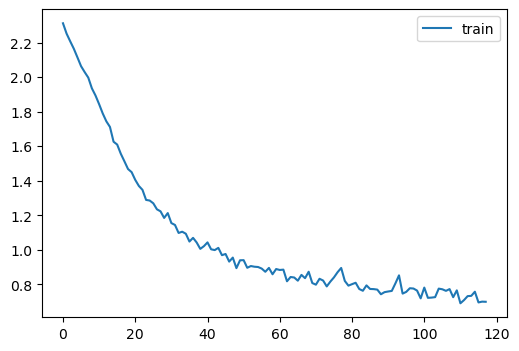

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, 
             cbs=[MetricCB(accuracy=MulticlassAccuracy()), ProgressCB(True)]).fit(2)

In [ ]:
import nbdev; nbdev.nbdev_export()